> ### EEE4423: Deep Learning Lab

# LAB \#9: Interpretation&Attention: Grad-CAM

<h4><div style="text-align: right"> Due date: 2022.05.06  </div> <br>
<div style="text-align: right"> Please upload your file @ yscec by 9 AM in the form of [ID_Name_Week9.ipynb]. </div></h4>

### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span> 
- Each team must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).

<h2><span style="color:blue">[2017142047] [한민규]</span> </h2>

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2022-05-05 10:19:21.225050


## Grad-CAM with pretrained model(AlexNet[2], VGGnet[3])

## Gradient-weighted Class Activation Mapping(Grad-CAM)[1]
>- A techinique for producing 'visual explanations' for decisions from a CNN-based models
>- Higlights the most important (discriminative) image regions related to the specific class
>- Making CNN-based models more transparent
>- Unlike in CAM, any architectural changes or retraining are not needed from any CNN-based networks

<img src="https://docs.google.com/uc?export=view&id=1fIcX1gPOSk1Q6tt4QHUpf0LvQYhb60gE" alt="no_image" style="width: 900px;"/>

### Framework of Grad-CAM
>- A generic version of Class Activation Map(CAM)
>- Using **gradient information** flowing into the last convolutional layer of the CNN to understanding the importance of each neuron for a decision
>- Compute a weighted sum of the feature maps of the last convolutional layer to produce CAM 
>>- Gradient of the score for class c, $y_c$, with respect to feature maps($A^k$) of the last convolutional layer, $\frac{\partial y^c}{\partial A^k}$
>>- These gradients are global-average-pooled to obtain the neuron importance weights ($\alpha_k^c$) : 
$\frac{1}{Z} \sum_{i}\sum_{j} \frac{\partial y^c}{\partial A_ij^k}$ <br>
>>- Grad-CAM mask produced with weighted combination of activation maps, followed by a ReLU: $L_{Grad-CAM}^c = ReLU(\sum_{k} \alpha_k^cA^k)$ 
>
> ++ **We don't use Guided Backpropagation in this part**

<img src="https://docs.google.com/uc?export=view&id=1fPgSB_Bq6PHAnSvtDBI25NYcSMNZmsqO" alt="no_image" style="width: 900px;"/>

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import cv2
import io
import requests
import os 
import copy

from PIL import Image
from collections import OrderedDict

%matplotlib inline

In [3]:
# For torchsummary
try:
    from torchsummary import summary
except ModuleNotFoundError:
    !pip install torchsummary
    from torchsummary import summary
    pass

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# hyper-parameters
image_size = 224
num_classes = 1000

### Model (Pre-trained models)

In [6]:
print('STEP 3: CREATE MODEL CLASS (Pre-trained models)')

STEP 3: CREATE MODEL CLASS (Pre-trained models)


#### 1.Write codes for the pretrained model (AlexNet and VGG-16) [2 points]
>- Hint: All learnable parameters' sizes of two models are in the 9th cell below <br>

#### 1.1 AlexNet [1 point]
>- Maxpooling after each convolutional layer
>- Use ReLU as an activation function
>- Dropout before the 1st and 2nd fully-connected layers

| **Layer** | **Kernel size** | **stride** | **padding** |
|:---:|:---:|:---:|:---:|
| 1st Conv | 11 | 4 | 2 |
| MaxPool | 3 | 2 | 0 |
| 2nd Conv | 5 | 1 | 2 |
| MaxPool | 3 | 2 | 0 |
| 3rd Conv | 3 | 1 | 1 |
| 4th Conv | 3 | 1 | 1 |
| 5th Conv | 3 | 1 | 1 |
| MaxPool | 3 | 2 | 0 |



In [7]:
#Pre-trained AlexNet from model_zoo
pretrained_AlexNet = {'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',}

class AlexNet_Block(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, stride, padding, maxpool = False):
        super(AlexNet_Block, self).__init__()
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding)
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.MaxPool = maxpool
        
    def forward(self, x):
        if self.MaxPool:
            return self.max_pool(self.relu(self.conv(x)))
        return self.relu(self.conv(x))
    
class AlexNet(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            AlexNet_Block(3, 64, kernel_size=11, stride=4, padding=2, maxpool = True),
            AlexNet_Block(64, 192, kernel_size=5, stride=1, padding=2, maxpool = True),
            AlexNet_Block(192, 384, kernel_size=3, stride=1, padding=1),
            AlexNet_Block(384, 256, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(9216, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        
        return x

#### 1.2 VGGnet-16 [1 point]
>- No batch normalization and initializtion of weights
>- Model configuration is in the dictionary '*cfg*'
>- Use ReLU as an activation function
>- Dropout before the 2nd and last fully-connected layers

| **Layer** | **Kernel size** | **stride** | **padding** |
|:---:|:---:|:---:|:---:|
| Conv | 3 | 1 | 1 |
| MaxPool | 2 | 2 | 0 |



In [8]:
#Pre-trained VGGnet-16 from model_zoo
pretrained_vgg = {
    'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
    'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',
    'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
}

cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}
 
class VGGnet(nn.Module):
    def __init__(self, features, num_classes=num_classes):
        super(VGGnet, self).__init__()
        self.features = features
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, num_classes)  
        )
       
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        
        return x
  
                
def make_layers(cfg, batch_norm=False):
    layers = []
    in_planes = 3
    for value in cfg:
        if value == "M":
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        else:
            layers.append(nn.Conv2d(in_planes, value, kernel_size=3, padding=1))
            layers.append(nn.ReLU())
            in_planes = value
    return nn.Sequential(*layers)

#### 2.Write codes for the model instantiation(AlexNet and VGG-16) [2 points]

In [9]:
print('STEP 4: INSTANTIATE MODEL CLASS')

# AlexNet
def alexnet(model, pretrained=False):
    pretrained_dict = model_zoo.load_url(pretrained_AlexNet['alexnet'])
    pretrained_key = list(pretrained_dict)
    new_state_dict = OrderedDict()
    model_dict = model.state_dict()
    
    # print(pretrained_dict.keys())
    # print(model_dict.keys())
    
    if pretrained:
        for i, (key, value) in enumerate(model_dict.items()):
            if 'weight' or 'bias' in key:
                new_state_dict[key] = pretrained_dict[pretrained_key[i]]       
        model.load_state_dict(new_state_dict)  
        
    return model

model_AlexNet = alexnet(AlexNet(), pretrained=True)

# VGG-16, no batch_norm
def vggnet(model, pretrained=False):
    pretrained_dict = model_zoo.load_url(pretrained_vgg['vgg16'])
    pretrained_key = list(pretrained_dict)
    new_state_dict = OrderedDict()
    model_dict = model.state_dict()
    
    # print(pretrained_dict.keys())
    # print(model_dict.keys())
    
    if pretrained:
        for i, (key, value) in enumerate(model_dict.items()):
            if 'weight' or 'bias' in key:
                new_state_dict[key] = pretrained_dict[pretrained_key[i]]
        model.load_state_dict(new_state_dict)
        
    return model

model_VGGnet = VGGnet(make_layers(cfg['D'], batch_norm=False))
model_VGGnet = vggnet(model_VGGnet, pretrained=True)

STEP 4: INSTANTIATE MODEL CLASS


In [10]:
print("AlexNet's Summary:")
model_AlexNet.to(device)
summary(model_AlexNet, (3, 224, 224))


print("\nVGGnet's Summary:")
model_VGGnet.to(device)
summary(model_VGGnet, (3, 224, 224))

AlexNet's Summary:


/home/jovyan/.venv/torch1.9.0-py3.8-cuda11.1/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
     AlexNet_Block-4           [-1, 64, 27, 27]               0
            Conv2d-5          [-1, 192, 27, 27]         307,392
              ReLU-6          [-1, 192, 27, 27]               0
         MaxPool2d-7          [-1, 192, 13, 13]               0
     AlexNet_Block-8          [-1, 192, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         663,936
             ReLU-10          [-1, 384, 13, 13]               0
    AlexNet_Block-11          [-1, 384, 13, 13]               0
           Conv2d-12          [-1, 256, 13, 13]         884,992
             ReLU-13          [-1, 256, 13, 13]               0
    AlexNet_Block-14          [-1, 256,

### Grad-CAM mask generating and visualizing with given test images

In [11]:
#test images with ImageNet class number
test_list = (('../dataset/lab09/test_images/kingsnake.jpg', 56),
             ('../dataset/lab09/test_images/cat_dog.png', 243),
             ('../dataset/lab09/test_images/cat_dog.png', 282),
             ('../dataset/lab09/test_images/pizza.jpg', 963))

#imagenet class
imagenet_class = {56: 'king snake', 243: 'bull mastiff', 282: 'tiger cat', 963: 'pizza'}

#### Grad-CAM generator class 
#### 3.Write codes for the Grad-CAM generator class [6 points]
>- Use pre-trained models
>- Similar to CAM generator class
>- *save_gradient* : A backward hook function to save gradients w.r.t our target convolutional features
>>- Hook up this function to the target features in *forward_model* part of *GradCAM* class
>>- *register_hook()* is a function for tensor (e.g. itermediate features) 
>>- *register_backward_hook* is a function for module (e.g. nn.Conv2d) 
>>- References for hook function: [4],[5]<br>
>- *forward_model* : Forward pass of our pretrained model to produce the score of class($y^c$) and activation maps($A^k$)
>- *gen_CAM* : Generating Grad-CAM mask with two inputs(*img*: input image, *one_hot_target*: one-hot-class of image)
>>1. Produce feature maps and the score of class
>>2. Computing gradient of the score for class with respect to the feature maps of the last convolutional layer
>>>- Backward pass with *one_hot_target* input
>>3. Global averaging of the gradients to obtain the weights
>>4. Grad-CAM mask generating (weighted sum of the feature maps)
>>5. Resizing the mask to the input image's size
>>>- *cv2.resize* function or other functions 
>>6. ReLU to obtain a final mask 
>>7. min-max normalization of mask for visualizing
>
>++ **The feature maps (activations) are the intermediate results of network before last pooling layer like the ones in CAM**



In [12]:
print(model_VGGnet.features[-2])
print(model_AlexNet.features[-2])

ReLU()
ReLU()


In [13]:
class GradCAM():
    def __init__(self, model):
        self.model = model
        self.model.eval()
        self.gradient = None
        self.h = None
    
    # A backward hook function to save gradients(weights for visualizing)
    def save_gradient(self, grad): 
        self.gradient = grad
    
    def forward_model(self,x):
        # forward until ReLU
        feature = self.model.features[:-1](x)

        # register hook
        self.h = feature.register_hook(self.save_gradient)

        x = self.model.features[-1](feature)
        x = x.view(x.size(0), -1)
        x = self.model.classifier(x)
        
        return feature, x
    
    def gen_CAM(self, img, one_hot_target):
        # Produce feature maps(=conv_feature) and the score(=output) of class
        conv_feature, output = self.forward_model(img)
        self.model.zero_grad()

        # Computing gradient of the score for class with respect to the feature maps of the last convolutional layer
        one_hot_target_index = torch.argmax(one_hot_target)
        output[:, one_hot_target_index].backward()

        # Global averaging of the gradients to obtain the weights
            # self.gradient : (1, channel, width, height)
            # -> global average pooling -> self.gradient : (1, channel, 1, 1)
        grad_gap = F.adaptive_avg_pool2d(self.gradient, (1,1))
        
        # Grad-CAM mask generating (weighted sum of the feature maps)
        grad_cam = conv_feature * grad_gap

        # ReLU to obtain a final mask
        grad_cam = grad_cam.cpu().detach().numpy()
        grad_cam = np.sum(grad_cam, 1).squeeze()
        grad_cam = np.maximum(grad_cam, 0)
        
        # Resizing the mask to the input image's size
        grad_cam = cv2.resize(grad_cam, (img.size(2),img.size(3)))
        # min-max normalization of mask for visualizing
        grad_cam = (grad_cam-np.min(grad_cam))/(np.max(grad_cam) - np.min(grad_cam) + 1e-08)
        
        return grad_cam

In [14]:
# image array to image tensor
def preprocess_image(img, resize_img=True):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    if resize_img:
        img = img.resize((224,224))
    img_arr = np.float32(img)
    img_arr = img_arr.transpose(2, 0, 1) 

    for c, _ in enumerate(img_arr):
        img_arr[c] /= 255
        img_arr[c] -= mean[c]
        img_arr[c] /= std[c]

    img_tensor = torch.from_numpy(img_arr).float()
    img_tensor = torch.unsqueeze(img_tensor,0)
    
    return img_tensor

#image tensor to image array
def reprocess_image(img):
    img = torch.squeeze(img,0)
    mean = [-0.485, -0.456, -0.406]
    std = [1/0.229, 1/0.224, 1/0.225]
    
    img_re = copy.copy(img.cpu().data.numpy())
    
    for c in range(3):
        img_re[c] /= std[c]
        img_re[c] -= mean[c]
        
    img_re[img_re > 1] = 1
    img_re[img_re < 0] = 0
    img_re = np.round(img_re * 255)

    img_re = np.uint8(img_re).transpose(1, 2, 0)
    
    return img_re

#### Grad_CAM Visulaization with given test images


#### 1. AlexNet 


target : 56 243 282 963


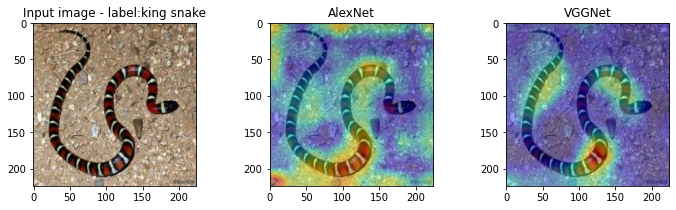

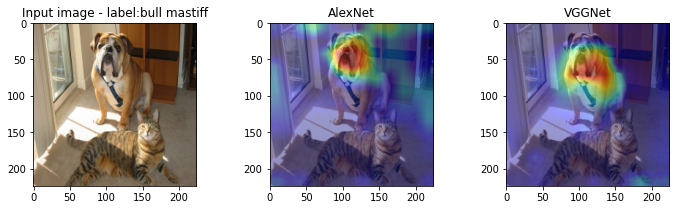

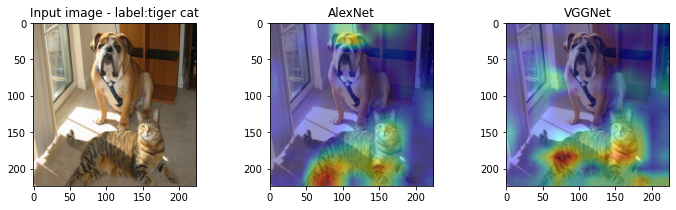

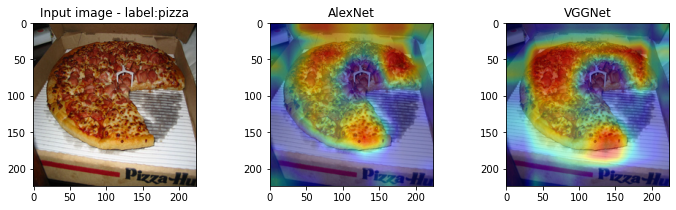

In [15]:
# Instantiation
gradcam_Alex = GradCAM(model_AlexNet)
gradcam_VGG = GradCAM(model_VGGnet)

print("target : 56 243 282 963")

for i in range(len(test_list)):
    img_path = test_list[i][0]
    target_class = test_list[i][1]
    
    one_hot_target = torch.zeros([1, num_classes], dtype=torch.float)
    one_hot_target[0][target_class] = 1
    one_hot_target = one_hot_target.to(device)
    
    img_ = Image.open(img_path).convert('RGB')
    img = preprocess_image(img_)
    img = img.to(device)
    
    cam_img_AlexNet = gradcam_Alex.gen_CAM(img, one_hot_target)
    cam_img_VGGNet = gradcam_VGG.gen_CAM(img, one_hot_target)

    fig = plt.figure(figsize=(12, 3))
    fig.add_subplot(1,3,1).set_title('Input image - label:{}'.format(imagenet_class[target_class]))
    plt.imshow(reprocess_image(img))
    fig.add_subplot(1,3,2).set_title('AlexNet')
    plt.imshow(reprocess_image(img))
    plt.imshow(cam_img_AlexNet, alpha=0.4, cmap='jet')
    fig.add_subplot(1,3,3).set_title('VGGNet')
    plt.imshow(reprocess_image(img))
    plt.imshow(cam_img_VGGNet, alpha=0.4, cmap='jet')
    plt.show()

## Guided Grad-CAM: Grad-CAM with Guided Backpropagation
>- Grad-CAM visualization is class-discriminative (i.e. localize the target category) but not high-resolution (i.e. capture fine-grained detail) 
>- Pixel-space gradient visualizations such as Guided Backpropagation highlights fine-grained details in the image
>- Two methods are fused to combine these two aspects (Pointwise multiplication in the figure below)

<img src="https://docs.google.com/uc?export=view&id=1ByM4truwzT7-arXpc8jee-nHbM9QUg1X" alt="no_image" style="width: 900px;"/>

### Guided Backpropagation[6]
> - Before Guided Backprogation : two approaches for visualizing
>> 1.The deconvolutional network ('deconvnet') an approach to visualizing concepts learned by neurons of a CNN [7]
>> - Given a high-level feature map, the 'deconvnet' inverts the data flow of a CNN, going from neuron activations in the given layer down to an input image
>> - Then the reconstructed image shows the part of the input image that is most strongly activating neurons in the given layer 
>> - Reference for 'deconvnet' : [8] <br>
>>    
>> <img src="https://docs.google.com/uc?export=view&id=1aLCwRfv_4XrRBoqyFOhGiau-fg6QW-Zs" alt="no_image" style="width: 900px;"/>
>> 2.An alternative way of visualizing the part of an image that most activates a given neuron is to use a simple backward pass of the activtaion of that neuron after a forward pass ('backpropagation') 
>
>- These two methods differ mainly in the way they handle backpropagtion through the rectified linear nonlinearity(ReLU) as in the figure below
>- **Guided Backpropagation** combines these two methods: <br> 
> Rather than masking out values corresponding to negative entries of the top gradient('deconvnet') or bottom data('backpropagation), masking out the values for which at least one of these values is negative 

<img src="https://docs.google.com/uc?export=view&id=15Yp2ze2PRK5cUvh6-DE4cSY7BZRxnYYW" alt="no_image" style="width: 900px;"/>

### Guided Backpropagation Visualization

In [16]:
class GBackprop():
    def __init__(self, model):
        self.model = model
        self.model.eval()
        # First layer of network where we register hook to
        self.first_layer = self.model.features[0]
        self.gradient = None 
        # hook functions to relus
        self.hook_relu()

    def hook_img_grad(self, grad):
        self.gradient = grad
        
    # register hook to module(ReLU)
    def hook_relu(self):
        # To pass only positive gradients at ReLU
        def relu_gradient(module, grad_input, grad_output):
            if isinstance(module, nn.ReLU):
                return (torch.clamp(grad_input[0], min=0.0),)
        
        for module in self.model.features.modules():
            if isinstance(module, nn.ReLU):
                module.register_backward_hook(relu_gradient)
    
    def forward_model(self,x):
        x = self.model.features(x)
        x = x.view(x.size(0), -1)
        x = self.model.classifier(x)
        return x
    
    def gen_mask(self, img, one_hot_target):
        img.register_hook(self.hook_img_grad)
        
        output = self.forward_model(img)
        self.model.zero_grad()
        
        # for gradient computing with our specified class
        output.backward(gradient = one_hot_target)
        
        # our visualization mask (to array)
        self.gradient = self.gradient.detach().cpu().numpy()[0]
        
        # gradients mask 
        gradients_mask = self.gradient.transpose(1,2,0)
        gradients_mask = (gradients_mask - np.min(gradients_mask))/\
            (np.max(gradients_mask) - np.min(gradients_mask) + 1e-08)
        
        return self.gradient, gradients_mask 

#### 1.AlexNet


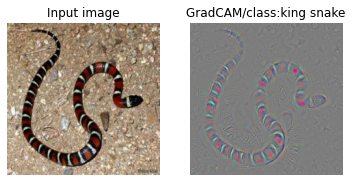

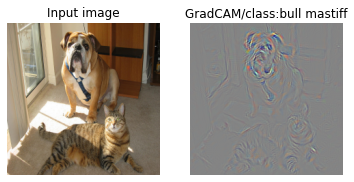

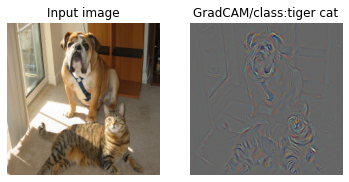

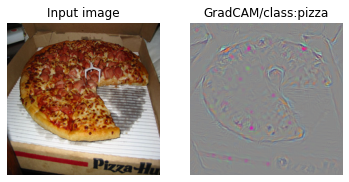

In [17]:
guided_backprop = GBackprop(model_AlexNet)

for i in range(len(test_list)):
    img_path = test_list[i][0]
    target_class = test_list[i][1]
    
    one_hot_target = torch.zeros([1, num_classes], dtype=torch.float)
    one_hot_target[0][target_class] = 1
    one_hot_target = one_hot_target.to(device)
    
    img_ = Image.open(img_path).convert('RGB')
    img = preprocess_image(img_)
    img = img.requires_grad_().to(device)
    
    gradient_numpy, mask = guided_backprop.gen_mask(img, one_hot_target)

    fig = plt.figure()
    fig.add_subplot(1,2,1).set_title('Input image')
    imgplot = plt.imshow(reprocess_image(img))
    plt.axis('off')
    fig.add_subplot(1,2,2).set_title('GradCAM/class:{}'.format(imagenet_class[target_class]))
    imgplot = plt.imshow(mask)
    plt.axis('off')

#### 2.VGGnet


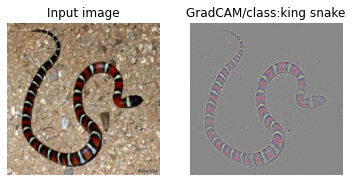

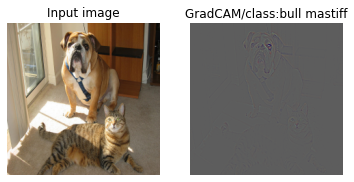

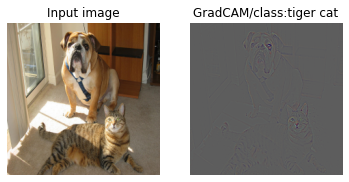

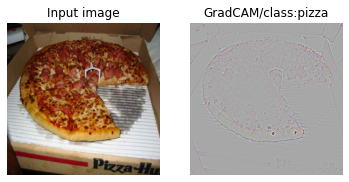

In [18]:
guided_backprop = GBackprop(model_VGGnet)

for i in range(len(test_list)):
    
    img_path = test_list[i][0]
    target_class = test_list[i][1]
    
    one_hot_target = torch.zeros([1, num_classes], dtype=torch.float)
    one_hot_target[0][target_class] = 1
    one_hot_target = one_hot_target.to(device)
    
    img_ = Image.open(img_path).convert('RGB')
    img = preprocess_image(img_)
    img = img.requires_grad_().to(device)
    
    gradient_numpy,mask = guided_backprop.gen_mask(img, one_hot_target)
    
    figure1 = plt.figure()
    figure1.add_subplot(1,2,1).set_title('Input image')
    imgplot = plt.imshow(reprocess_image(img))
    plt.axis('off')
    figure1.add_subplot(1,2,2).set_title('GradCAM/class:{}'.format(imagenet_class[target_class]))
    imgplot = plt.imshow(mask)
    plt.axis('off')

### Guided Grad-CAM visualization

#### 1.AlexNet

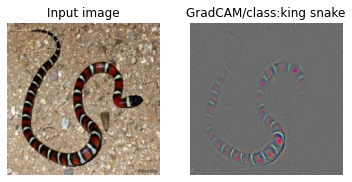

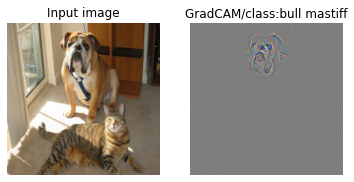

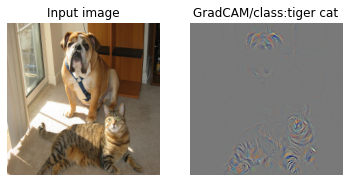

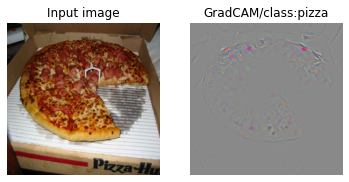

In [19]:
gradcam = GradCAM(model_AlexNet)
guided_backprop = GBackprop(model_AlexNet)

for i in range(len(test_list)):
    
    img_path = test_list[i][0]
    target_class = test_list[i][1]
    
    one_hot_target = torch.zeros([1, num_classes], dtype=torch.float)
    one_hot_target[0][target_class] = 1
    one_hot_target = one_hot_target.to(device)
    
    img_ = Image.open(img_path).convert('RGB')
    img = preprocess_image(img_)
    img = img.requires_grad_().to(device)
    
    cam_img = gradcam.gen_CAM(img, one_hot_target)    
    gradient_numpy, mask = guided_backprop.gen_mask(img, one_hot_target)

    guided_gradcam = np.multiply(cam_img, gradient_numpy).transpose(1,2,0)
    guided_gradcam = (guided_gradcam - np.min(guided_gradcam)) /\
            (np.max(guided_gradcam) - np.min(guided_gradcam) + 1e-08)
    
    figure1 = plt.figure()
    figure1.add_subplot(1,2,1).set_title('Input image')
    imgplot = plt.imshow(reprocess_image(img))
    plt.axis('off')
    figure1.add_subplot(1,2,2).set_title('GradCAM/class:{}'.format(imagenet_class[target_class]))
    imgplot = plt.imshow(guided_gradcam)
    plt.axis('off')

#### 2. VGGnet

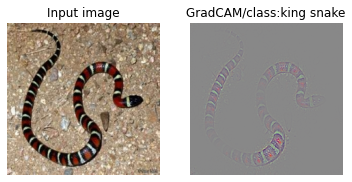

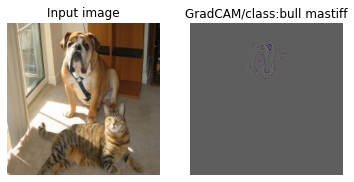

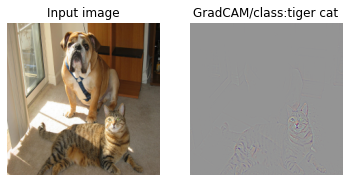

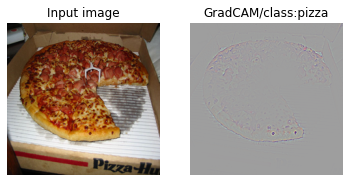

In [20]:
gradcam = GradCAM(model_VGGnet)
guided_backprop = GBackprop(model_VGGnet)

for i in range(len(test_list)):
    
    img_path = test_list[i][0]
    target_class = test_list[i][1]
    
    one_hot_target = torch.zeros([1, num_classes], dtype=torch.float)
    one_hot_target[0][target_class] = 1
    one_hot_target = one_hot_target.to(device)
    
    img_ = Image.open(img_path).convert('RGB')
    img = preprocess_image(img_)
    img = img.requires_grad_().to(device)

    cam_img = gradcam.gen_CAM(img, one_hot_target)    
    gradient_numpy, mask = guided_backprop.gen_mask(img, one_hot_target)

    guided_gradcam = np.multiply(cam_img, gradient_numpy).transpose(1,2,0)
    guided_gradcam = (guided_gradcam - np.min(guided_gradcam))/\
            (np.max(guided_gradcam) - np.min(guided_gradcam) + 1e-08)
  
    figure1 = plt.figure()
    figure1.add_subplot(1,2,1).set_title('Input image')
    imgplot = plt.imshow(reprocess_image(img))
    plt.axis('off')
    figure1.add_subplot(1,2,2).set_title('GradCAM/class:{}'.format(imagenet_class[target_class]))
    imgplot = plt.imshow(guided_gradcam)
    plt.axis('off')

### *References*
[1] https://arxiv.org/pdf/1610.02391.pdf <br>
[2] https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf <br>
[3] https://arxiv.org/pdf/1409.1556.pdf <br>
[4] https://bob3rdnewbie.tistory.com/320 <br>
[5] https://pytorch.org/docs/stable/autograd.html#torch.Tensor.register_hook <br>
[6] https://arxiv.org/pdf/1412.6806.pdf <br>
[7] https://arxiv.org/pdf/1311.2901.pdf <br>
[8] https://medium.com/@jamesvanneman/paper-club-visualizing-and-understanding-convolutional-networks-629fef9ceb8b <br>

Grad-CAM을 직접 구현함에 있어 상당히 어려운 부분이 많았지만 gradient부터 backpropagation, guided backpropagation까지 딥러닝의 학습과정을 다시 깊게 공부할 수 있었다.

Grad-CAM에서 AlexNet과 VGG16을 사용하였는데, classification이 더 잘되는 모델인 VGG16이 더욱 class discriminative한 성질을 보여주었다. 이는 Cat과 Dog이 같이 있는 사진에서 target class가 tiget cat일 때 AlexNet은 dog에 대해서 CAM에 나타나는 반면 VGG에서는 오직 cat에 대해서만 activation이 되어 있는 것을 확인할 수 있다.